In [17]:
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import datetime
import numpy as np

This notebook is a baseline on predicting energy production consumption of different kinds of prosumers using lightgbm.We use the current data and some time feature to predict the data at the same time 48 hours later.

# load data

In [18]:
data = pd.read_csv('../data/train.csv')
data['datetime'] = pd.to_datetime(data['datetime'])
data.shape

(2018352, 9)

In [19]:
data.describe()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
count,2.018352e+06,2.018352e+06,2.018352e+06,2.017824e+06,2018352.0,2018352,2.018352e+06,2.018352e+06,2.018352e+06
mean,7.297034e+00,5.368261e-01,1.898927e+00,2.748556e+02,0.5,2022-07-20 08:29:25.326166016,3.218746e+02,1.009176e+06,3.304538e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,2021-09-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,0.000000e+00,1.000000e+00,3.780000e-01,0.0,2022-02-14 04:00:00,1.660000e+02,5.045878e+05,1.600000e+01
50%,7.000000e+00,1.000000e+00,2.000000e+00,3.113300e+01,0.5,2022-07-21 09:30:00,3.230000e+02,1.009176e+06,3.300000e+01
75%,1.100000e+01,1.000000e+00,3.000000e+00,1.802062e+02,1.0,2022-12-24 14:00:00,4.790000e+02,1.513763e+06,5.000000e+01
max,1.500000e+01,1.000000e+00,3.000000e+00,1.548027e+04,1.0,2023-05-31 23:00:00,6.370000e+02,2.018351e+06,6.800000e+01
std,4.780990e+00,4.986421e-01,1.081766e+00,9.095024e+02,0.5,NaN,1.826343e+02,5.826482e+05,1.959059e+01


In [20]:
data.isnull().sum()

county                  0
is_business             0
product_type            0
target                528
is_consumption          0
datetime                0
data_block_id           0
row_id                  0
prediction_unit_id      0
dtype: int64

<Axes: >

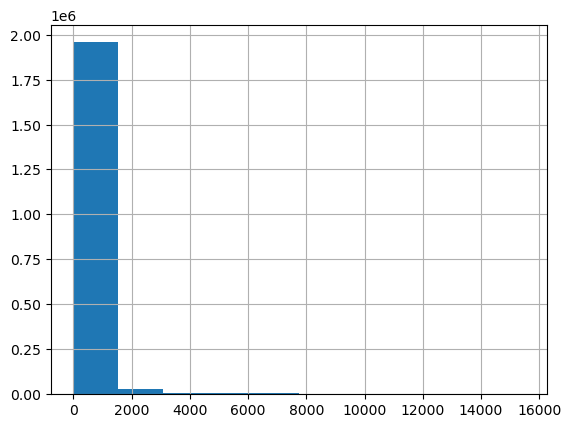

In [21]:
data['target'].hist()

As we can see, there are 2018352 rows and 9 columns in the dataset.This is a bit of a large amount of data and there are some missing target values. Therefore, we choose to use lightgbm for training.

# Feature engineering

We add time series features and target values 48h later for each row.

In [22]:
# dropping the columns that are not needed
data = data.drop(columns=['data_block_id','row_id','prediction_unit_id'])

In [23]:
# Generate the target value from 48 lag
df_lag48h = data.copy()
df_lag48h['datetime'] = df_lag48h['datetime'] + pd.Timedelta('2 days')
df_lag48h = df_lag48h.rename(columns={'target':'target_lag48h'})
df_train = data.merge(df_lag48h, on=['datetime','county','is_business','product_type','is_consumption'], how='left')

In [24]:
# Generating time features
def get_time_feature(df, col='ts'):
    df_copy = df.copy()

    df_copy['hour'] = df_copy[col].dt.hour
    df_copy['day'] = df_copy[col].dt.day
    df_copy['weekday'] = df_copy[col].dt.weekday
    df_copy['week'] = df_copy[col].dt.isocalendar().week
    df_copy['month'] = df_copy[col].dt.month
    df_copy['quarter'] = df_copy[col].dt.quarter

    return df_copy

df_train = get_time_feature(df_train, col='datetime')
df_train

,county,is_business,product_type,target,is_consumption,datetime,target_lag48h,hour,day,weekday,week,month,quarter
0,0,0,1,0.713,0,2021-09-01 00:00:00,NaN,0,1,2,35,9,3
1,0,0,1,96.590,1,2021-09-01 00:00:00,NaN,0,1,2,35,9,3
2,0,0,2,0.000,0,2021-09-01 00:00:00,NaN,0,1,2,35,9,3
3,0,0,2,17.314,1,2021-09-01 00:00:00,NaN,0,1,2,35,9,3
4,0,0,3,2.904,0,2021-09-01 00:00:00,NaN,0,1,2,35,9,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,188.167,23,31,2,22,5,2
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,0.000,23,31,2,22,5,2
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,31.484,23,31,2,22,5,2
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,0.000,23,31,2,22,5,2


In [25]:
df_train = df_train.dropna()

In [26]:
df_train

,county,is_business,product_type,target,is_consumption,datetime,target_lag48h,hour,day,weekday,week,month,quarter
5856,0,0,1,0.793,0,2021-09-03 00:00:00,0.713,0,3,4,35,9,3
5857,0,0,1,107.129,1,2021-09-03 00:00:00,96.590,0,3,4,35,9,3
5858,0,0,2,0.000,0,2021-09-03 00:00:00,0.000,0,3,4,35,9,3
5859,0,0,2,19.630,1,2021-09-03 00:00:00,17.314,0,3,4,35,9,3
5860,0,0,3,0.977,0,2021-09-03 00:00:00,2.904,0,3,4,35,9,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,188.167,23,31,2,22,5,2
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,0.000,23,31,2,22,5,2
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,31.484,23,31,2,22,5,2
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,0.000,23,31,2,22,5,2


In [27]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2008656 entries, 5856 to 2018351
Data columns (total 13 columns):
 #   Column          Dtype         
---  ------          -----         
 0   county          int64         
 1   is_business     int64         
 2   product_type    int64         
 3   target          float64       
 4   is_consumption  int64         
 5   datetime        datetime64[ns]
 6   target_lag48h   float64       
 7   hour            int32         
 8   day             int32         
 9   weekday         int32         
 10  week            UInt32        
 11  month           int32         
 12  quarter         int32         
dtypes: UInt32(1), datetime64[ns](1), float64(2), int32(5), int64(4)
memory usage: 170.5 MB


Because input data types for lightgbm can only be int, float, category and bool. So we need to convert the data type of the category feature to category with.astype("category").Meanwhile, convert the data type of ['week'] from Uint32 to int32

In [28]:
cat_cols = [
            "county",
            "is_business",
            "product_type",
            "is_consumption",
        ]
df_train[cat_cols] = df_train[cat_cols].astype("category")
df_train['week'] = df_train['week'].astype("int")
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2008656 entries, 5856 to 2018351
Data columns (total 13 columns):
 #   Column          Dtype         
---  ------          -----         
 0   county          category      
 1   is_business     category      
 2   product_type    category      
 3   target          float64       
 4   is_consumption  category      
 5   datetime        datetime64[ns]
 6   target_lag48h   float64       
 7   hour            int32         
 8   day             int32         
 9   weekday         int32         
 10  week            int32         
 11  month           int32         
 12  quarter         int32         
dtypes: category(4), datetime64[ns](1), float64(2), int32(6)
memory usage: 114.9 MB


In [29]:
df_train = df_train.drop(columns=['datetime'])

# Split of training set, test set, validation set

We set 80% of the data as the training set and 20% of the data as the test set. MAE is used as the evaluation index to evaluate the model performance.

In [30]:
X = df_train.drop(columns=["target"])
Y = df_train["target"]
train_size = 0.8
X_train, X_test = X.head(int(len(Y)*train_size)) , X.tail(int(len(Y)*(1-train_size)))
y_train, y_test = Y.head(int(len(Y)*train_size)) , Y.tail(int(len(Y)*(1-train_size)))

# Model training

In [33]:
from lightgbm import LGBMRegressor
params = {
    'objective': 'regression_l1', #MAE is used as the objective function of the model
    'verbose': -1 , #this parameter is used to suppress warnings
    'random_state': 1, #this parameter is used for reproducibility purpose

    'n_estimators': 1000,#number of trees
    'learning_rate': 0.05,#learning rate
    'num_leaves': 2**5,#number of leaves in full tree
    'max_depth': 5,#maximum depth of the tree
}

model = LGBMRegressor(**params)
model.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.05, max_depth=5, n_estimators=1000, num_leaves=32,
              objective='regression_l1', random_state=1, verbose=-1)

# Prediction and model evaluation

In [34]:
from sklearn.metrics import mean_absolute_error
y_predictions = model.predict(X_test)
MAE = mean_absolute_error(y_test, y_predictions)
print(f'MAE: {MAE}')

MAE: 94.30983187586453
